In [49]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import sys
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt
import imageio
import re
from tqdm import tqdm_notebook as tqdm

#### 1. Load dataset

In [50]:
# sort file list by name (digit firstly and then lower_case)
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(data, key=alphanum_key)

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


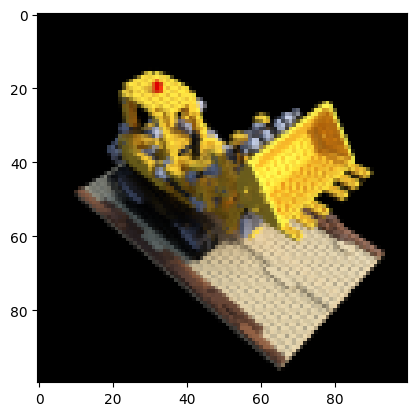

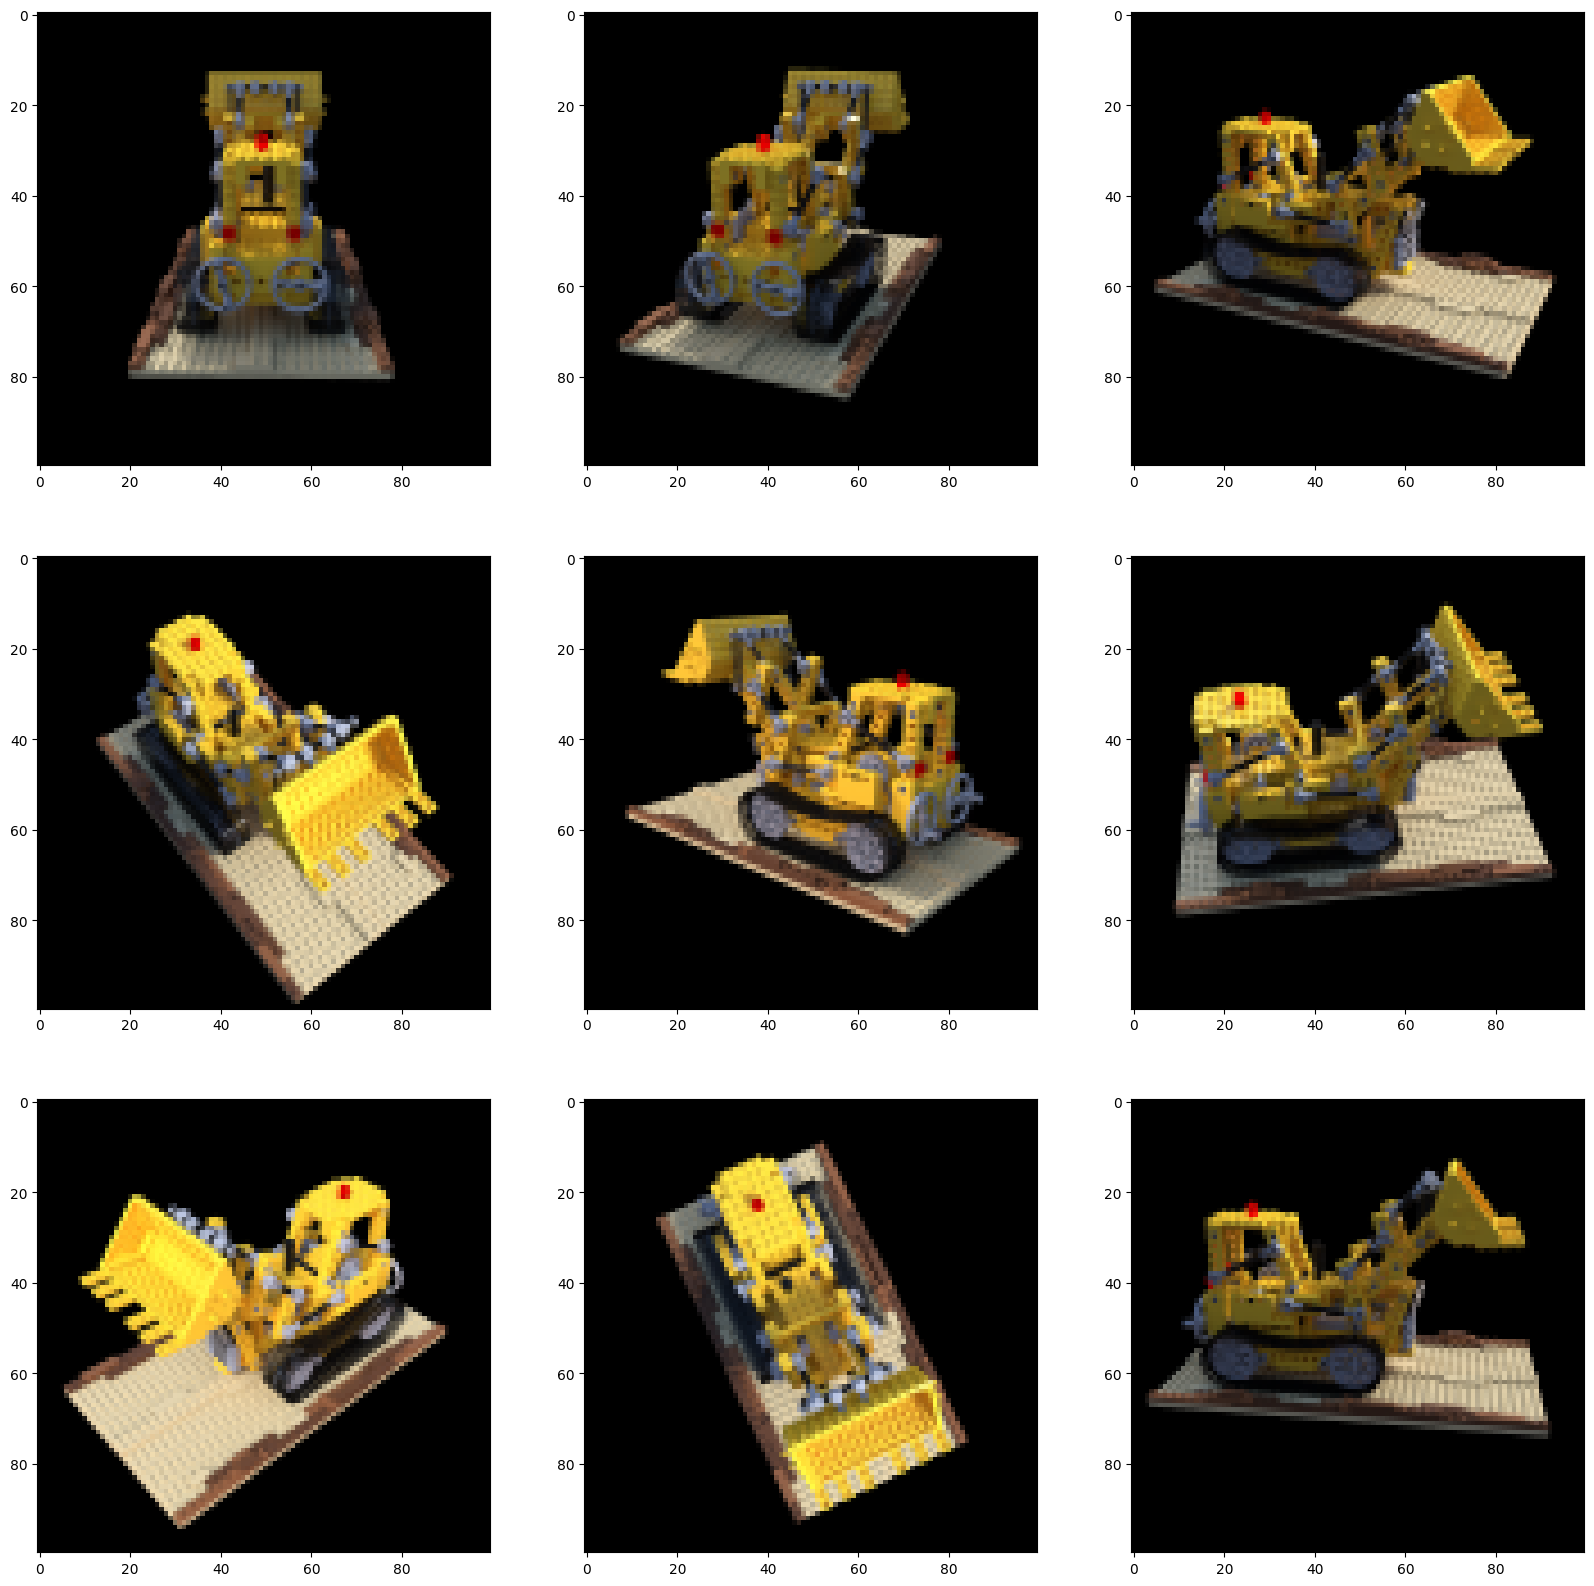

In [51]:
data = np.load('dataset/tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

# visualize image samples
img_samples = images[0:9]
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,20))
ax = ax.flatten()
for image_idx in range(9):
    # plot the image
    ax[image_idx].imshow(img_samples[image_idx])
plt.show()

#### 2. Build NeRF Training Model

In [52]:
# positional encoding
def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

L_embed = 6
embed_fn = posenc

In [53]:
# build model (8 layers, 256 channels each layer)
def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed)) # inputs = posenc(x)*3 = (1+2*6)*3 = 39, 3: position(x,y,z)
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs) # outputs = 4: (color,volume_density) = (r,g,b,sigma)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [54]:
# calculate parameters of rays: rays_o, rays_d
def get_rays(H, W, focal, c2w):
    
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')

    '''
    with the following definition:
    W: image width
    H: image height
    focal: camera focal
    (Cx,Cy,focal): image center position
    (i-Cx,j-Cy,focal): pixel position on the image
    camera position = (0,0,0) 
    we have:
    direction vector of rays after normalization: ((i-Cx)/focal, (j-Cy)/focal, 1)
    coordinate system transformation (Opencv/Colmap -> Opengl/NeRF): X'=X, Y'=-Y, Z'=-Z
    => final direction vector of rays: ((i-Cx)/focal, -(j-Cy)/focal, -1)
    '''
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)

    # rotate ray directions from camera frame to world frame => Pw = (R_c2w)*Pc
    # R_c2w: c2w[:3,:3] -> (3, 3)
    # dirs[..., np.newaxis, :]: (H, W, 1, 3)
    # c2w[:3,:3] * dirs[..., np.newaxis, :]: (H, W, 3, 3)
    rays_d = tf.reduce_sum(c2w[:3,:3] * dirs[..., np.newaxis, :], -1) # (H, W, 3)
    
    # get camera position in world coordinate -> T_c2w: c2w[:3,-1] -> (3, 1) = 3
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d)) # (H, W, 3)

    return rays_o, rays_d

In [55]:
# render rays
def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32): # fn -> network_fn, fn(inputs) -> outputs
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # -compute 3D query points-
    z_vals = tf.linspace(near, far, N_samples) # (64,)
    # add random bias
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples # (H, W, 64)
    # calculate 3D query points on camera rays: r(t) = o + td, while t is sample points on the ray -> z_vals
    pts = rays_o[...,None,:] + z_vals[...,:,None] * rays_d[...,None,:]
    # rays_o[...,None,:].shape = (H, W, 1, 3)
    # rays_d[...,None,:].shape = (H, W, 1, 3)
    # z_vals[...,:,None].shape = (H, W, 64, 1)
    # (z_vals[...,:,None] * rays_d[...,None,:]).shape = (H, W, 64, 3)
    # pts.shape = (H, W, 64, 3)

    # -run network-
    # flatten pts
    pts_flat = tf.reshape(pts, [-1,3]) # pts_flat.shape = (H*W*64, 3)
    # positional encoding on pts_flat
    pts_flat = embed_fn(pts_flat) # pts_flat.shape = (H*W*64, 39)
    # batchify the input data and run network to get outputs
    raw = batchify(network_fn)(pts_flat) # raw.shape = (H*W*64, 4), 4: outputs of model -> (r,g,b,sigma)
    # reshape the outputs
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4]) # raw.shape = (H, W, 64, 4)
    
    # -compute volume density and colors-
    # using relu function is to ensure that output volume density is nonnegative
    sigma_a = tf.nn.relu(raw[...,3]) # sigma_a.shape = (H, W, 64)
    # using sigmoid function is ensure that output color value is between 0 and 1
    rgb = tf.math.sigmoid(raw[...,:3]) # rgb.shape = (H, W, 64, 3)

    # -do volume rendering-
    # calculate distance between adjacent samples on the ray 
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1) 
    # calculate alpha -> [0, 1] with 0: fully transparent and 1: fully opaque
    alpha = 1.-tf.exp(-sigma_a * dists) # alpha.shape = (H, W, 64)
    '''
    calculate weights = T_i * alpha_i, while T_i = cumprod(1-alpha_i)

    tensorflow.math.cumprod(): the output for input [a, b, c] will be [a, a*b, a*b*c]
    exclusive = True: the output for input [a, b, c] will be [1, a, a*b]

    C(r)_hat = c1*alpha_1 + c2*alpha_2*(1-alpha_1) + ... + cn*alpha_n*(1-alpha_1)*...*(1-alpha_(n-1)) = C(r)*weights
    => weights = [alpha_1, alpha_2*(1-alpha_1), ..., alpha_n*(1-alpha_1)*...*(1-alpha_(n-1))]
    '''
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True) # weights.shape = (H, W, 64)
    
    # calculate rgb_map = weights * rgb, then sum along each ray: [r1 g1 b1] + [r2 g2 b2] + ... + [r64 g64 b64]
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) # rgb_map.shape = (H, W, 3)
    # calculate depth_map = weights * z_vals, then sum along each ray
    depth_map = tf.reduce_sum(weights * z_vals, -1) # depth_map.shape = (H, W, 1)
    # calculate acc_map along each ray
    acc_map = tf.reduce_sum(weights, -1) # acc_map.shape = (H, W, 1)

    return rgb_map, depth_map, acc_map

#### 3. Train Loop and Optimizer

In [60]:
# initialize model and optimizer
model = init_model()
optimizer = tf.keras.optimizers.Adam(1e-4)

# hyperparameters
N_samples = 32
N_iters = 20000
psnrs = []
iternums = []
i_plot = 500

0 0.004426237106323242 secs per iter


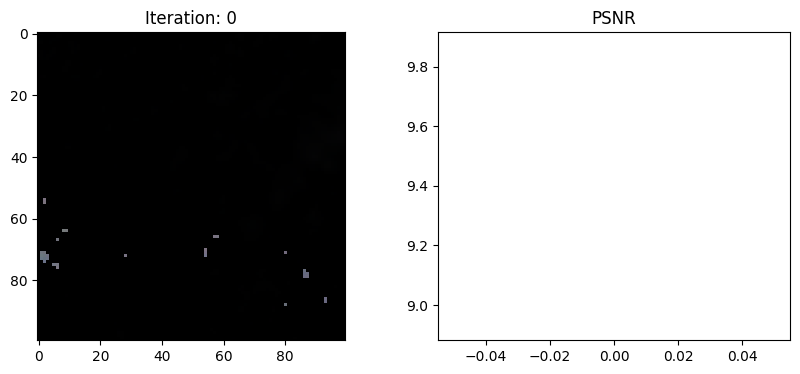

500 0.19818404293060302 secs per iter


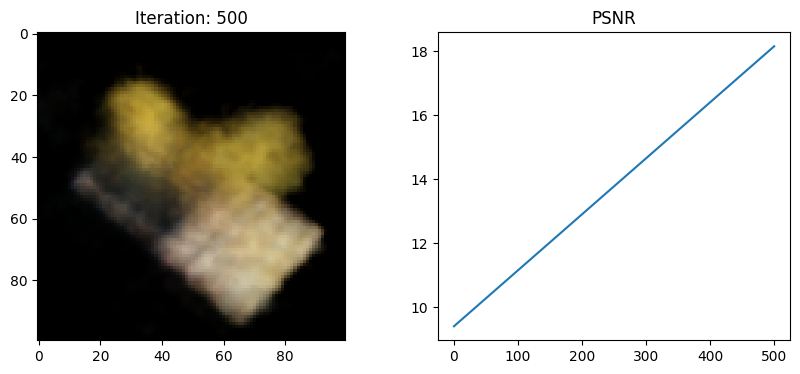

1000 0.20026910066604614 secs per iter


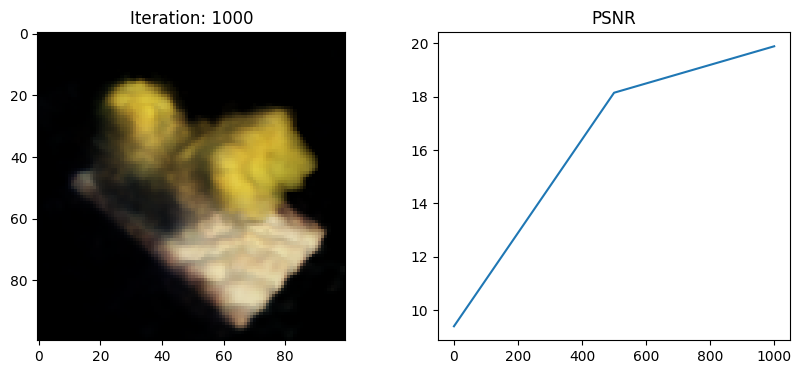

1500 0.19725930404663086 secs per iter


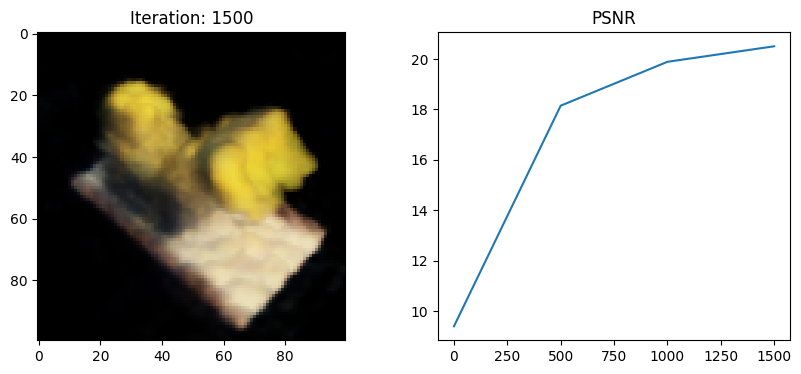

2000 0.1931296377182007 secs per iter


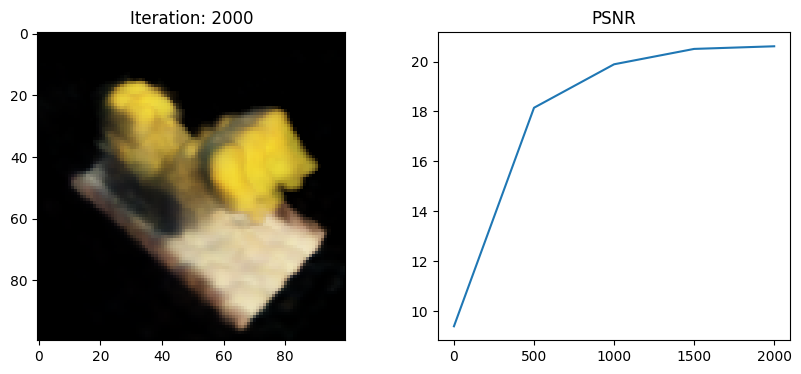

2500 0.19370593690872193 secs per iter


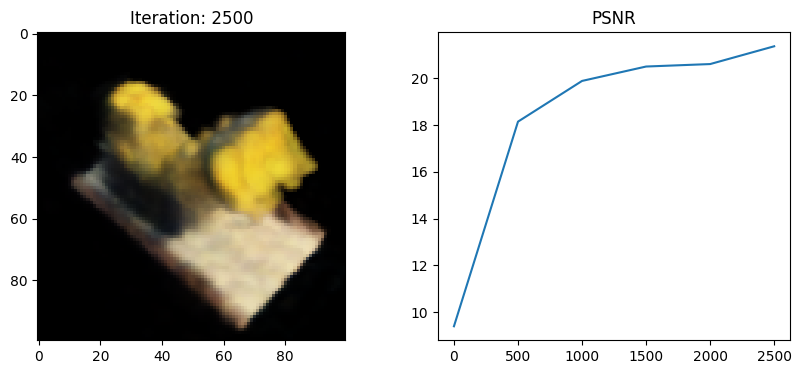

3000 0.19439193677902222 secs per iter


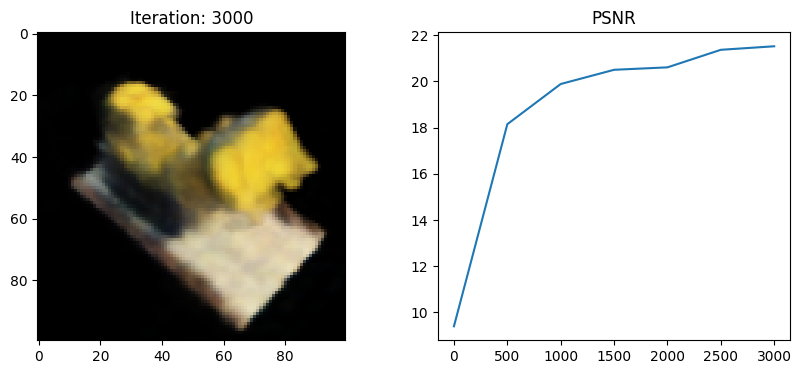

3500 0.1949027132987976 secs per iter


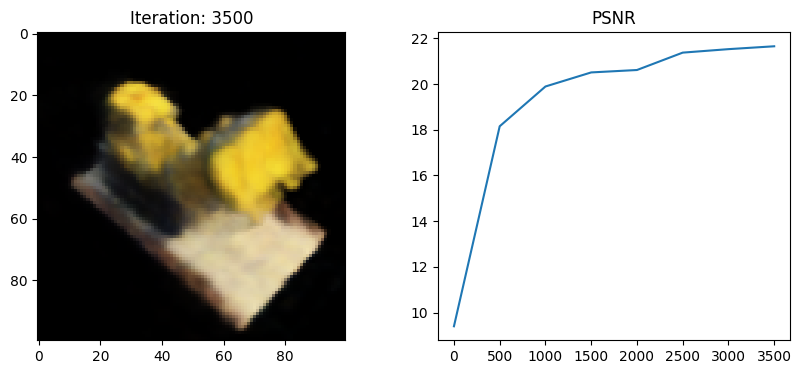

4000 0.19432307481765748 secs per iter


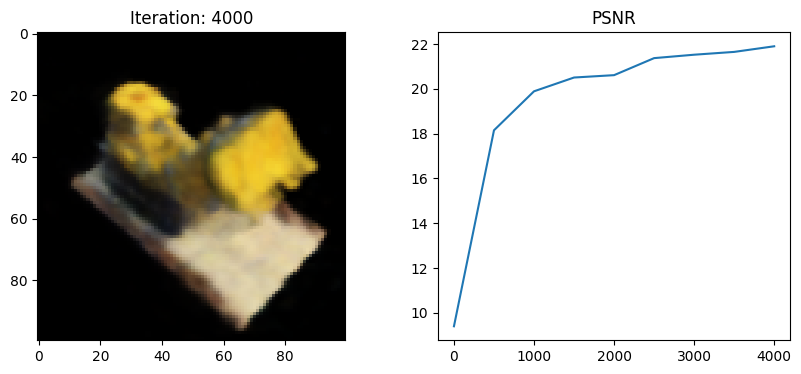

4500 0.19416303491592407 secs per iter


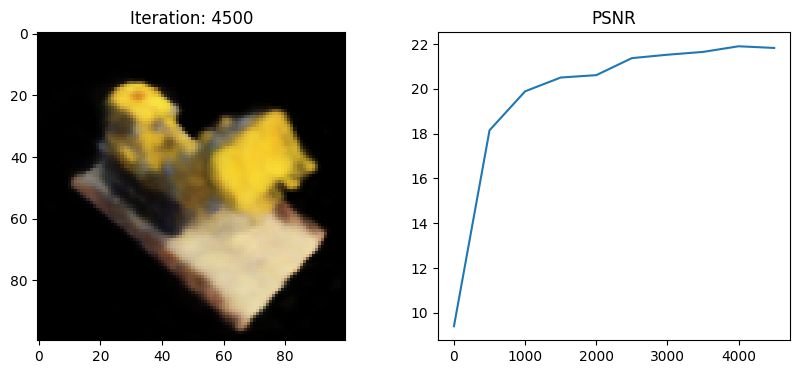

5000 0.19500826787948608 secs per iter


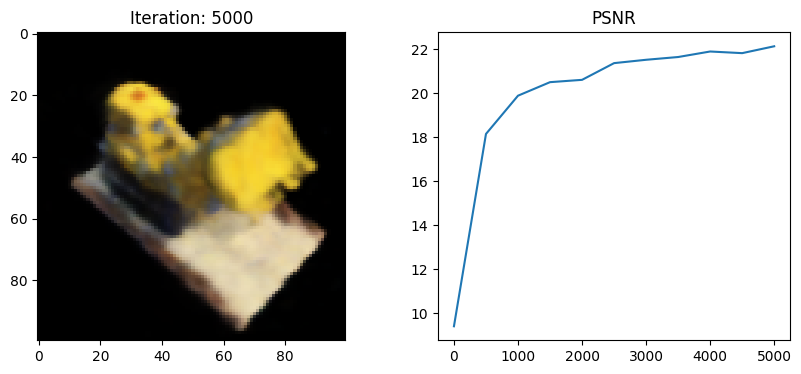

5500 0.19552203845977784 secs per iter


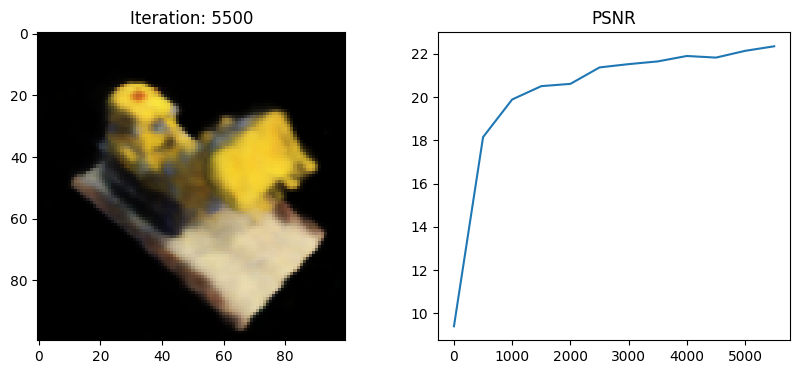

6000 0.19474328804016114 secs per iter


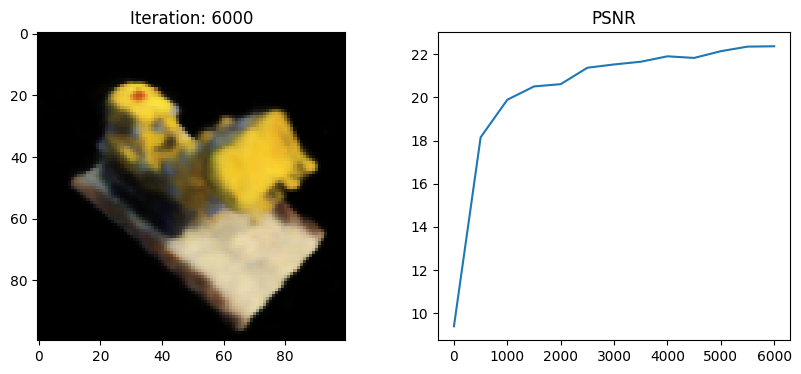

6500 0.19462580823898315 secs per iter


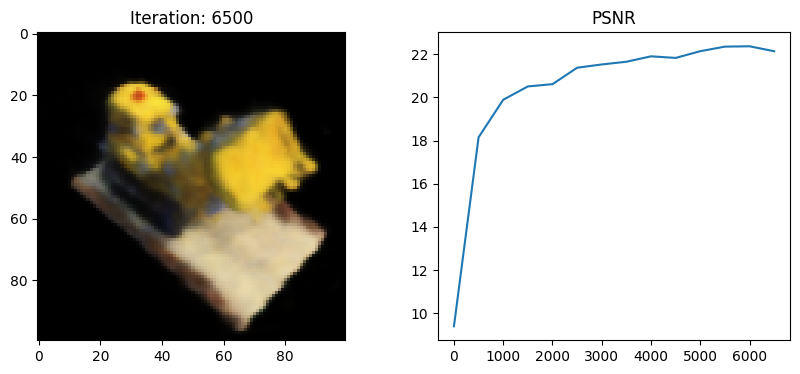

7000 0.19473872995376587 secs per iter


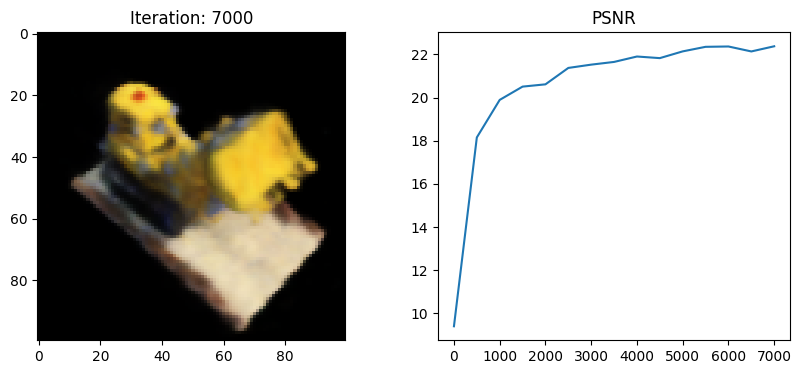

7500 0.19477740669250487 secs per iter


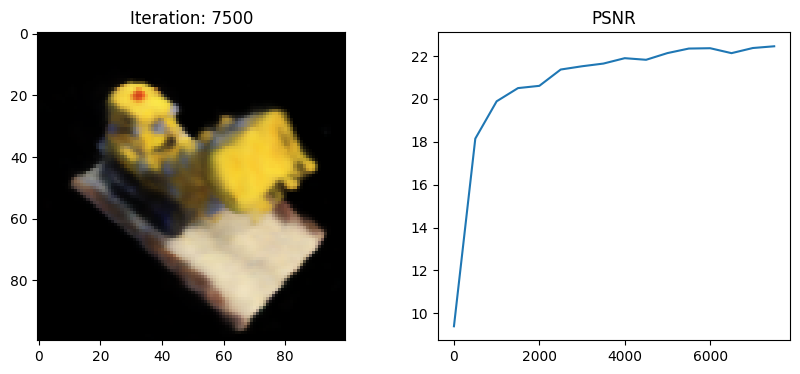

8000 0.19419624614715575 secs per iter


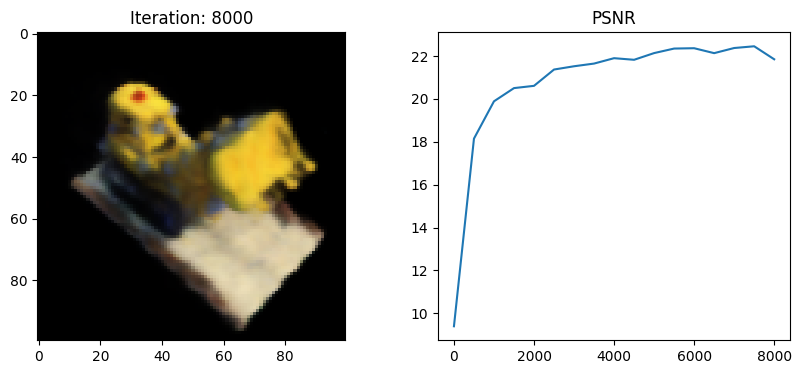

8500 0.19786400127410889 secs per iter


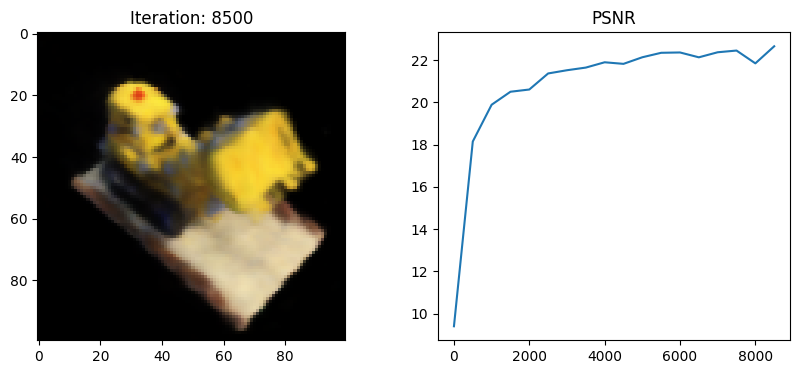

9000 0.19576320791244506 secs per iter


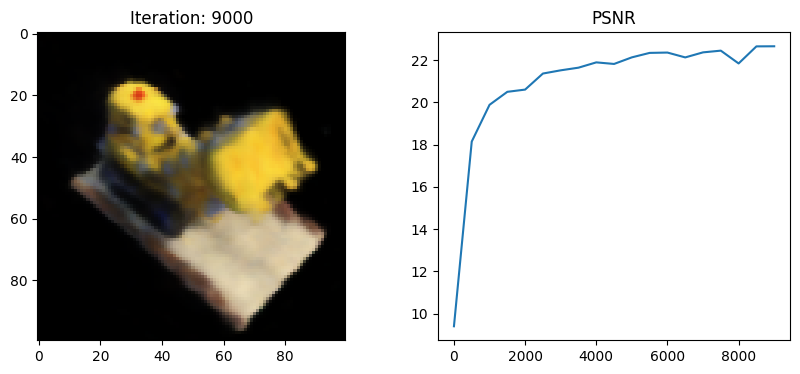

9500 0.19546588468551634 secs per iter


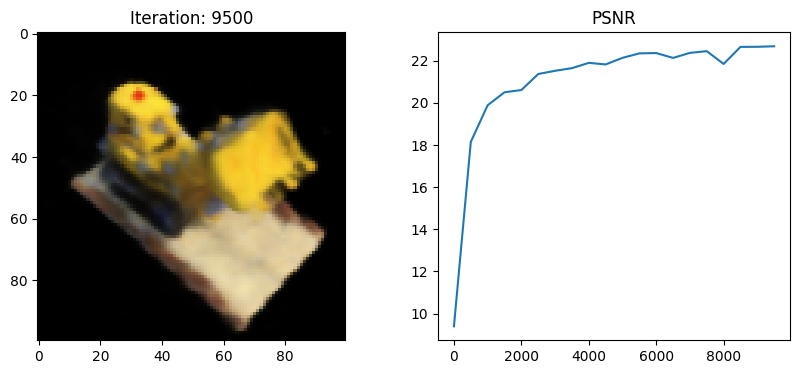

10000 0.1951639075279236 secs per iter


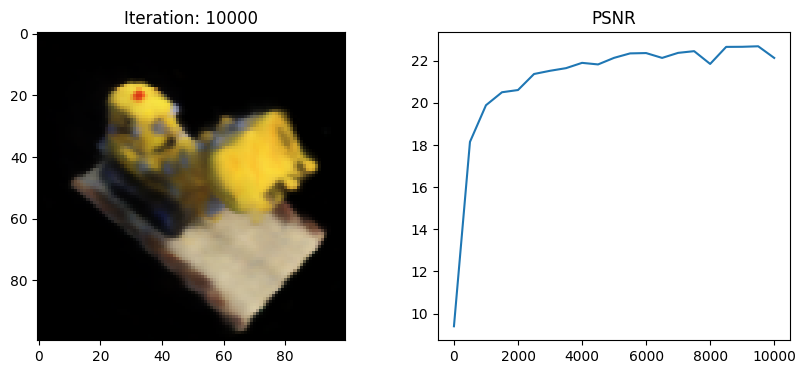

10500 0.19507239198684692 secs per iter


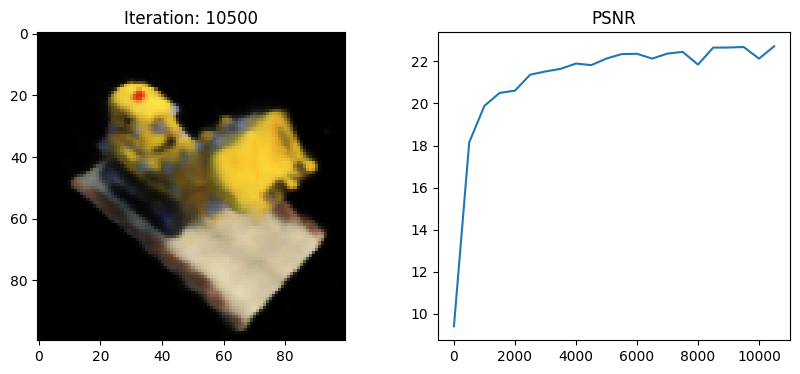

11000 0.19499117755889891 secs per iter


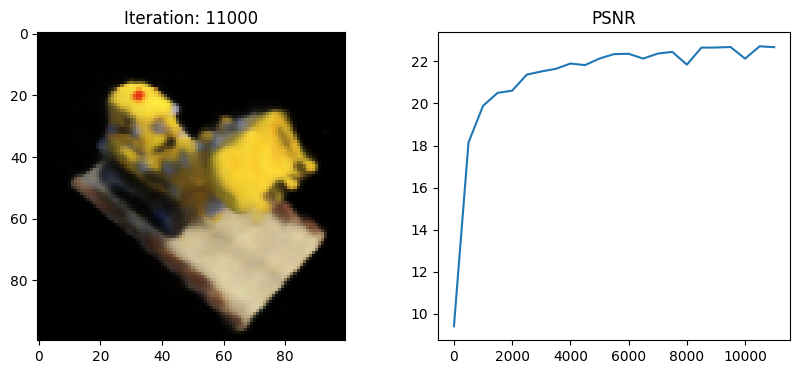

11500 0.19542109298706054 secs per iter


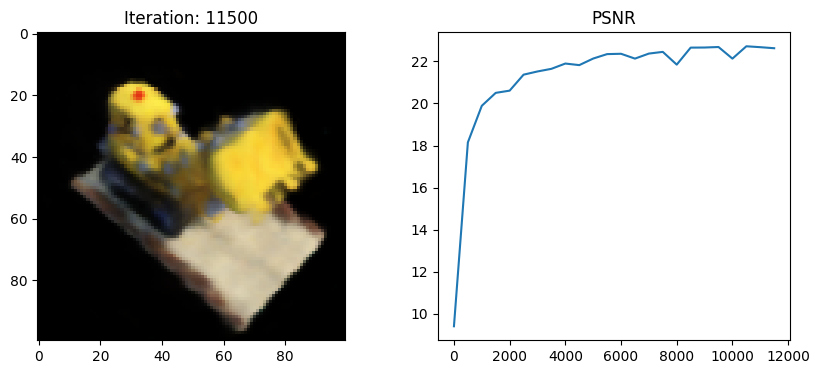

12000 0.1957766342163086 secs per iter


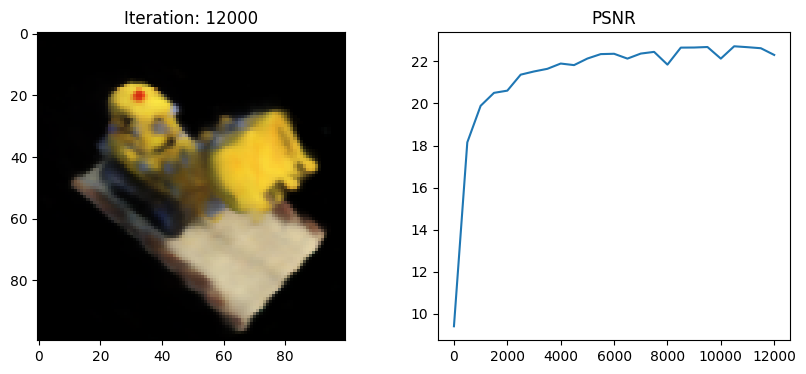

12500 0.19597890520095826 secs per iter


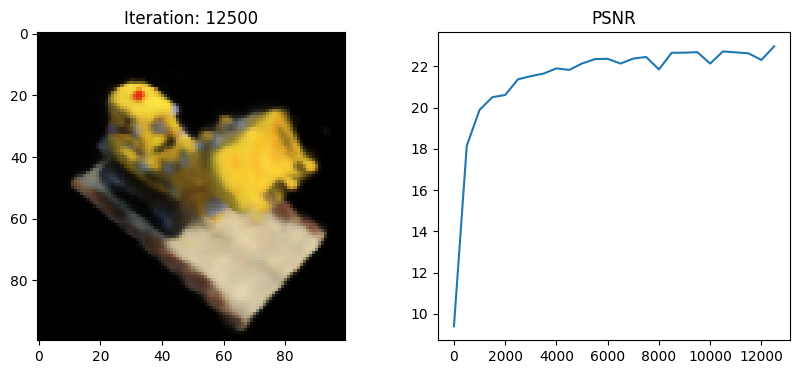

13000 0.19584730815887452 secs per iter


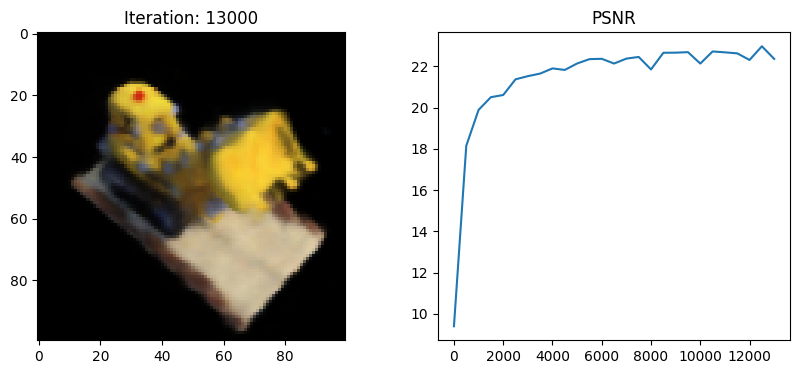

13500 0.1957053780555725 secs per iter


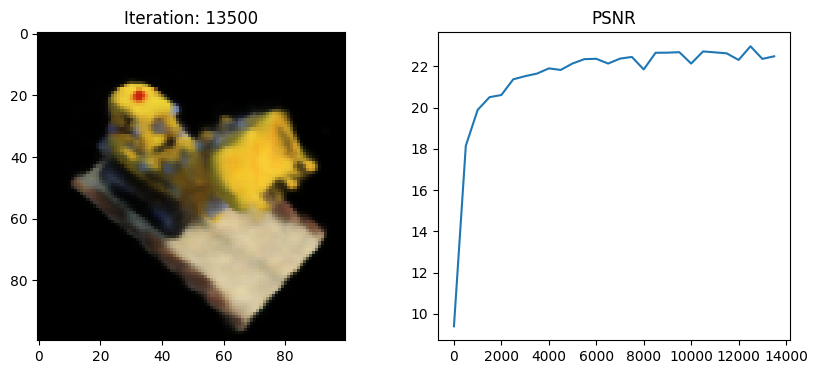

14000 0.19527402782440187 secs per iter


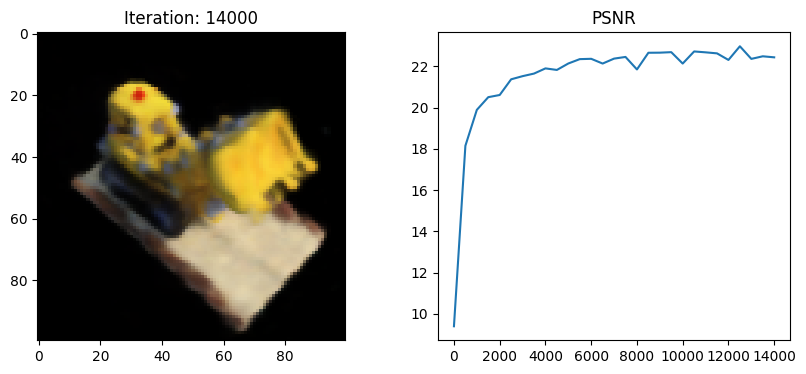

14500 0.1952432336807251 secs per iter


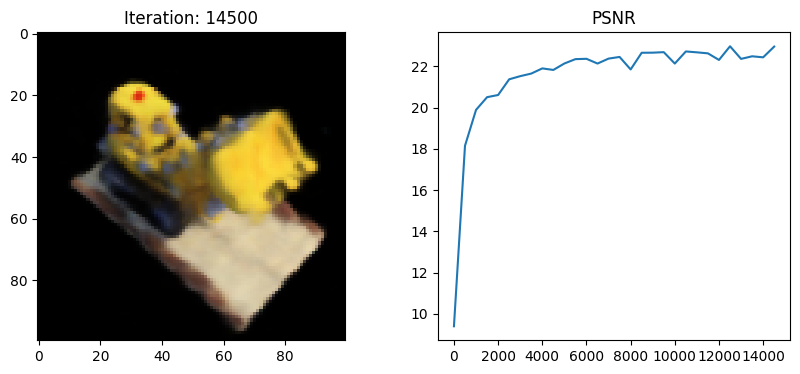

15000 0.1962401990890503 secs per iter


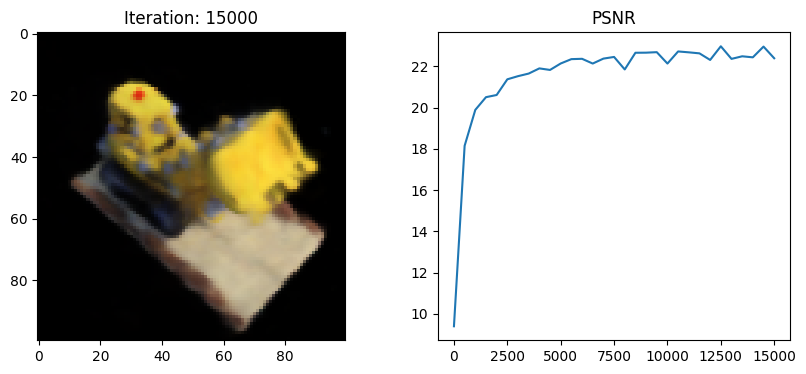

15500 0.19736404418945314 secs per iter


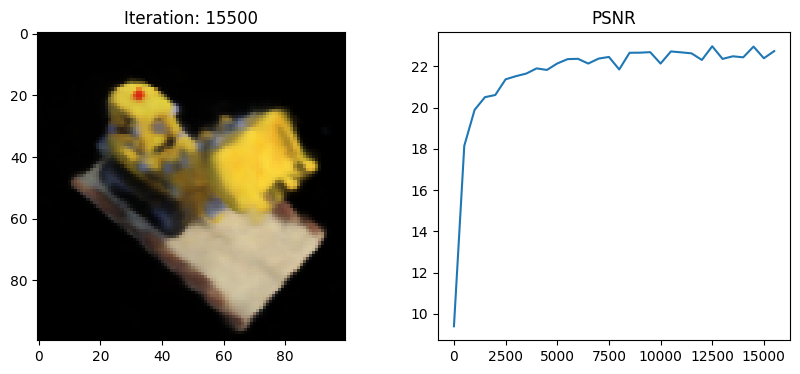

16000 0.1965756058692932 secs per iter


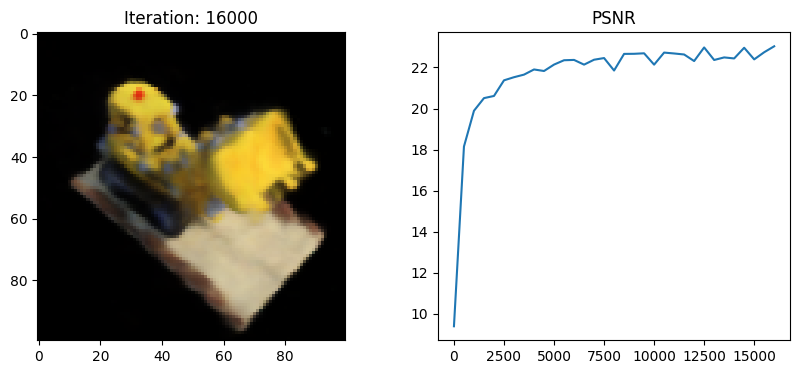

16500 0.19606668090820312 secs per iter


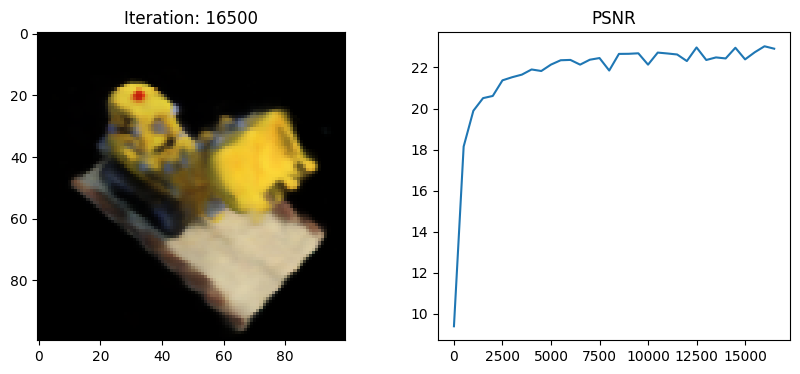

17000 0.19580701398849487 secs per iter


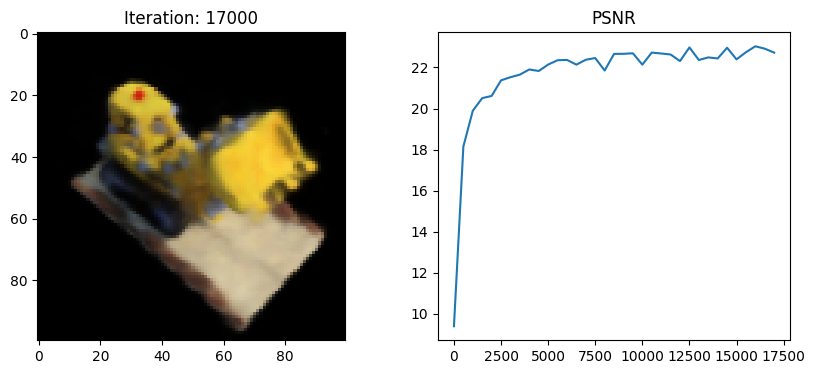

17500 0.1956790633201599 secs per iter


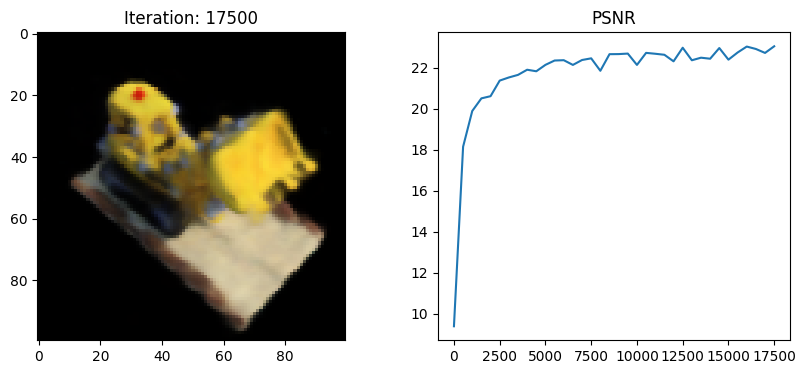

18000 0.1959040503501892 secs per iter


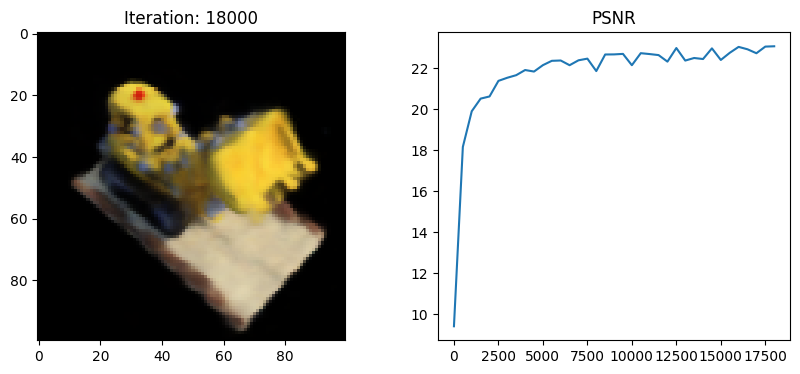

18500 0.1962440519332886 secs per iter


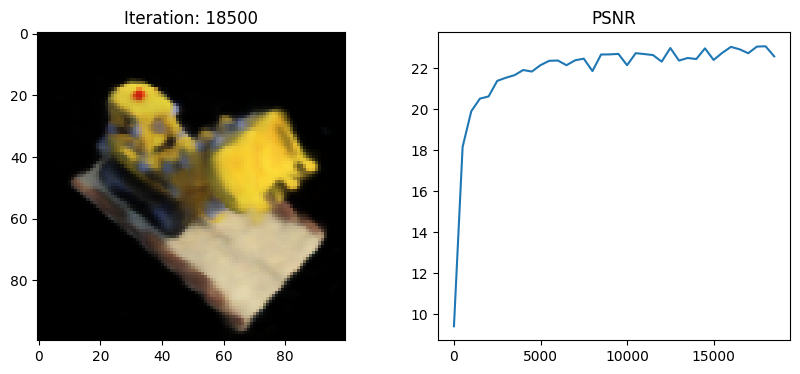

19000 0.19617181873321532 secs per iter


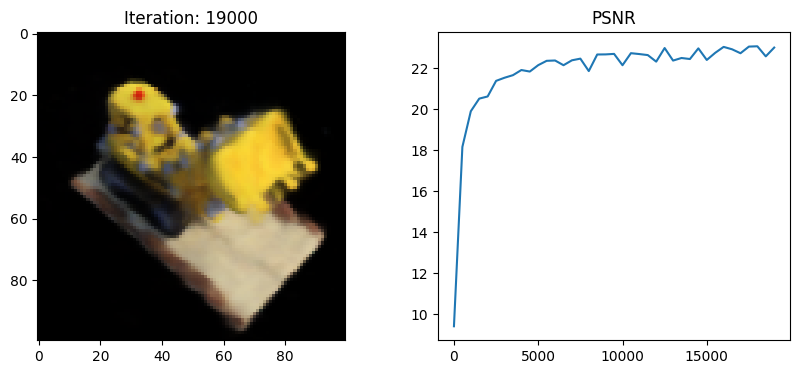

19500 0.196005765914917 secs per iter


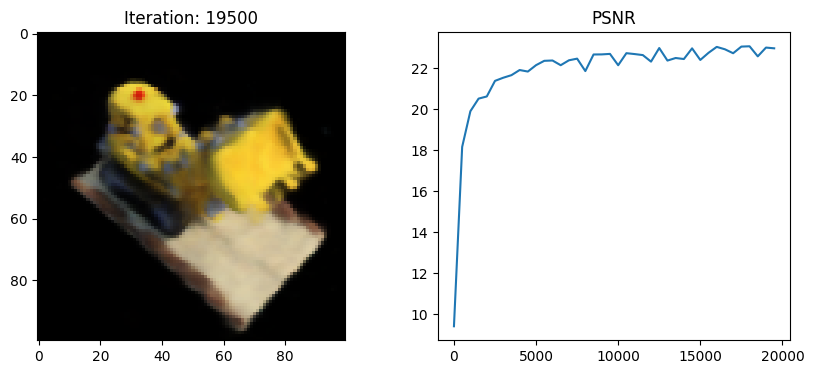

20000 0.1959520797729492 secs per iter


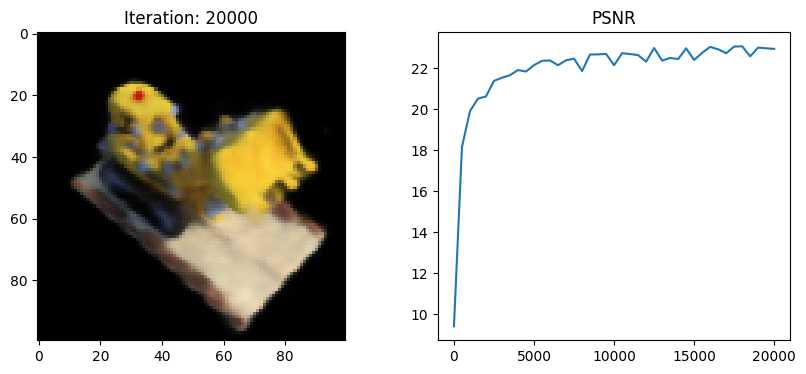

Training is done!


In [61]:
# train loop
import time
t = time.time()

for i in range(N_iters+1):
    img_i = np.random.randint(images.shape[0])
    target = images[img_i] # target.shape = (H, W, 3)
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)

    rays_o = tf.cast(rays_o, tf.float32)
    rays_d = tf.cast(rays_d, tf.float32)
    # print(rays_o.dtype, rays_d.dtype)

    # use tf.GradientTape() to record operations for automatic differentiation
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True) # rgb.shape = (H, W, 3)
        # tf.reduce_mean(): calculate mean of elements across dimensions of a tensor
        # tf.square(): return the square of the specified tensor’s elements
        loss = tf.reduce_mean(tf.square(rgb - target))
    # calculate gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    # apply optimizer to the gradients
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot == 0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # render sample view from test dataset for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        
        psnrs.append(psnr.numpy())
        iternums.append(i)

        # show rgb for logging
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        # plot PSNR for logging
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Training is done!')

#### 4. Interactive Visualization

In [66]:
# pip install ipympl
# include matplotlib graphs in notebook, next to the code
%matplotlib inline 
from ipywidgets import interactive, widgets

trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)

def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w

def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1) # use np.clip to limit the values of rgb array into an interval of [0,1]

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
print(interactive_plot.children)

output = interactive_plot.children[-1] # get the output() in the index of -1 from interactive_plot.children
output.layout.height = '400px'
interactive_plot

(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-30.0, description='phi', max=0.0, min=-90.0, step=0.01), FloatSlider(value=4.0, description='radius', max=5.0, min=3.0, step=0.01), Output())


interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

#### 5. Render 360-degree Video

In [67]:
frames = []

# use tqdm to iterate over a list
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7) # write multiple images to the specified file

/tmp/ipykernel_10343/872592457.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):


  0%|          | 0/120 [00:00<?, ?it/s]

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x6def700] Warning: data is not aligned! This can lead to a speed loss


In [71]:
# play the video
from IPython.display import HTML
from base64 import b64encode

mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)